In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA


In [2]:
data = pd.read_csv('./heart_attack.csv')
data.dropna(inplace=True)

In [3]:
data.isnull().sum()*100/len(data)

age         0.0
sex         0.0
cp          0.0
trtbps      0.0
chol        0.0
fbs         0.0
restecg     0.0
thalachh    0.0
exng        0.0
oldpeak     0.0
slp         0.0
caa         0.0
thall       0.0
output      0.0
dtype: float64

<Axes: >

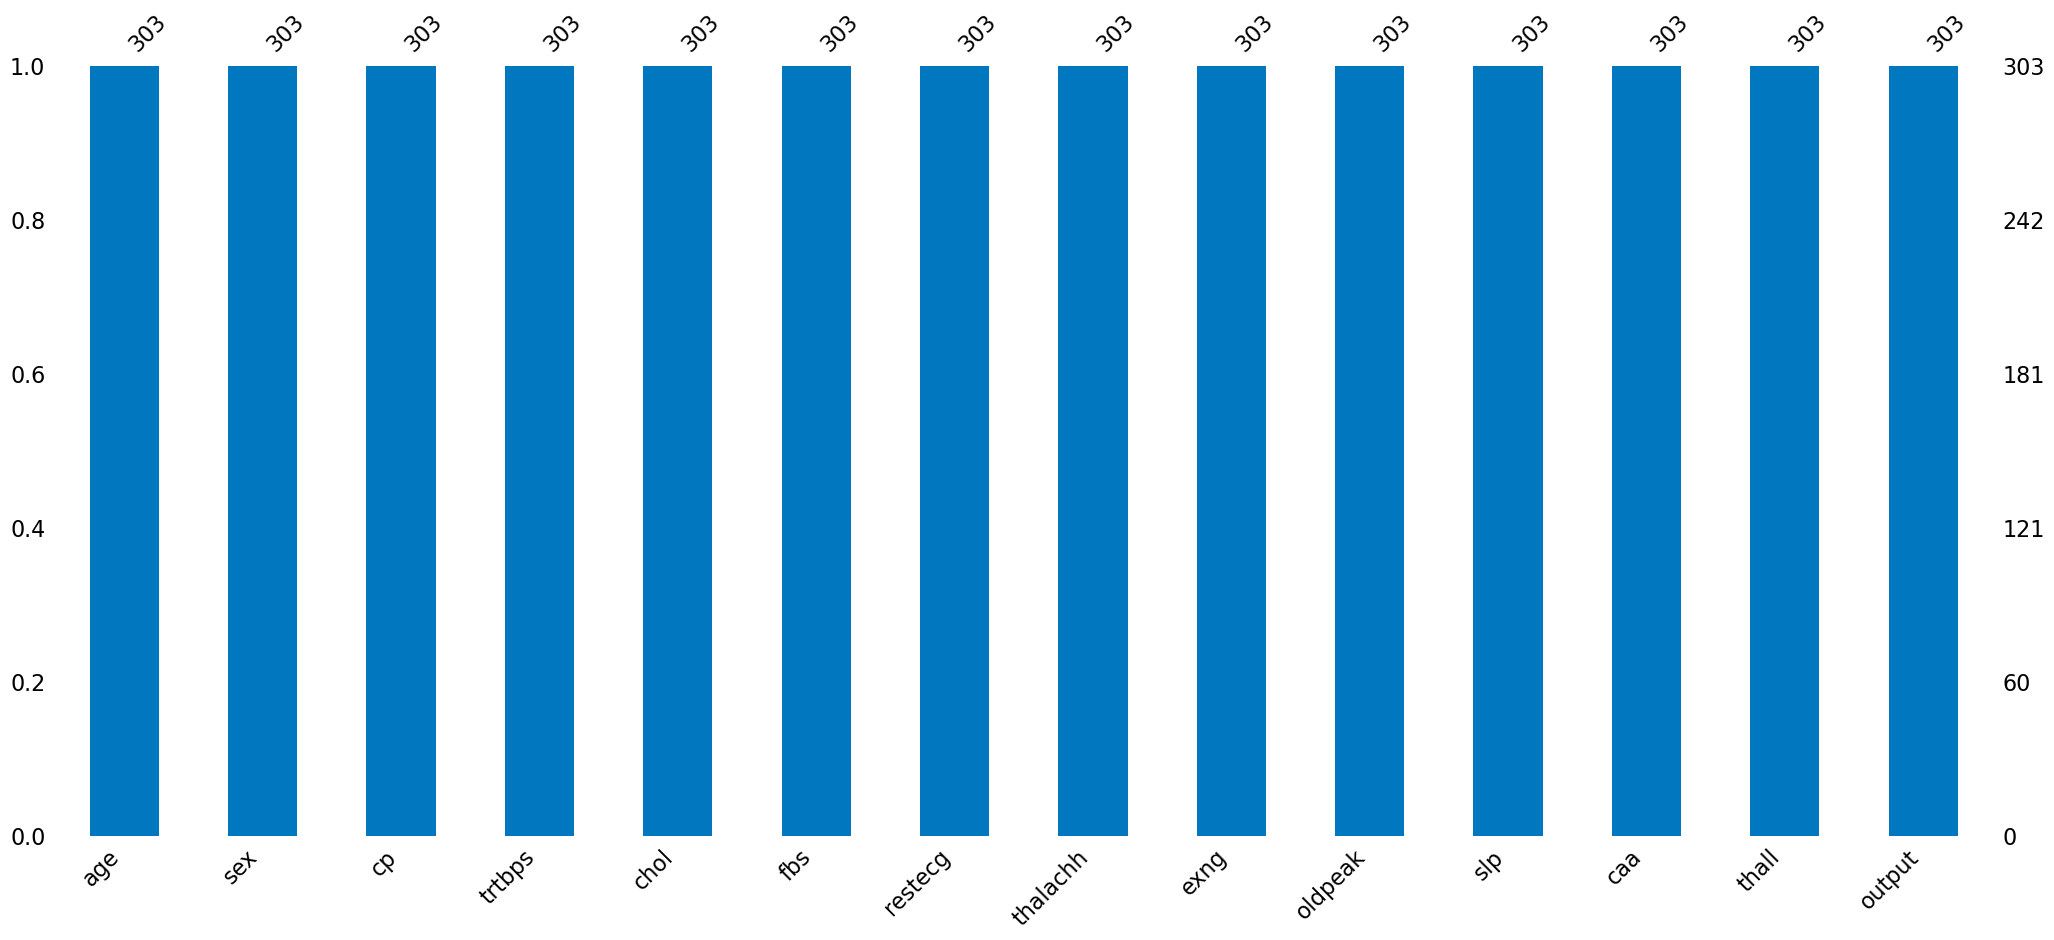

In [4]:
msno.bar(data, color="#0077be")

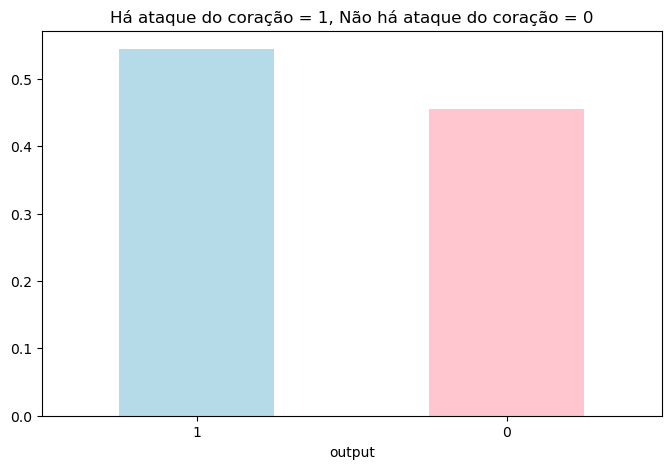

In [5]:
fig = plt.figure(figsize = (8,5))
data.output.value_counts(normalize = True).plot(kind='bar', color= ['lightblue','pink'], alpha = 0.9, rot=0)
plt.title('Há ataque do coração = 1, Não há ataque do coração = 0')
plt.show()

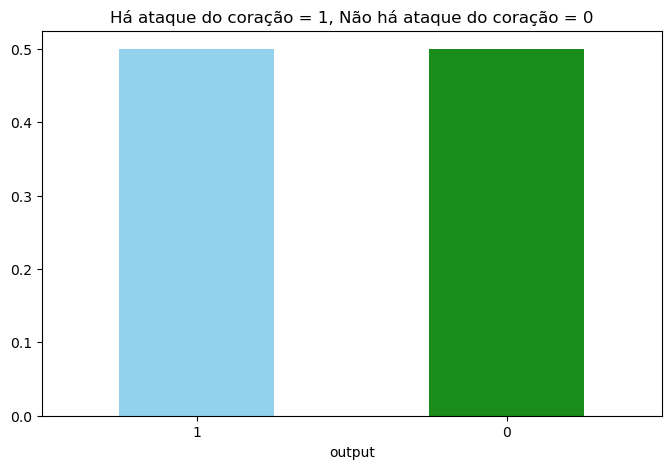

In [6]:
no = data[data.output == 0]
yes = data[data.output == 1]
no_oversampled = resample(no, replace=True, n_samples=len(yes), random_state=123)
oversampled = pd.concat([yes, no_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.output.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','green'], alpha = 0.9, rot=0)
plt.title('Há ataque do coração = 1, Não há ataque do coração = 0')
plt.show()

In [7]:
X_raw = data[['age','sex','cp','trtbps','chol','fbs','restecg','thalachh','exng','oldpeak','slp','caa','thall']]
Y_raw = data['output']

X_balanced = oversampled.drop(["output"], axis=1)
Y_balanced = oversampled["output"]

In [8]:
X_balanced.mean(axis=0)

age          54.724242
sex           0.687879
cp            0.924242
trtbps      131.221212
chol        246.639394
fbs           0.148485
restecg       0.560606
thalachh    148.084848
exng          0.339394
oldpeak       1.106061
slp           1.342424
caa           0.775758
thall         2.312121
dtype: float64

In [9]:
X_balanced_train, X_balanced_test, Y_balanced_train, Y_balanced_test = train_test_split(X_balanced, Y_balanced, test_size=0.2, random_state=42)

In [10]:
print(len(X_balanced_train))
print(len(X_balanced_train)/len(X_balanced))

264
0.8


In [11]:
pca = PCA(n_components=2)
pca.fit(X_balanced)

PCA(n_components=2)

In [12]:
Z = pca.transform(X_balanced)

In [13]:
Z.mean(axis=0)

array([1.19715685e-14, 6.20110024e-15])

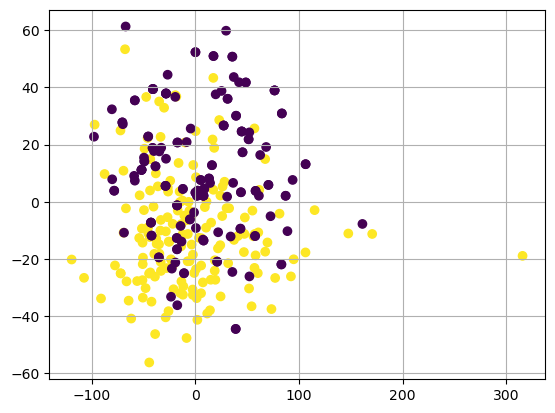

In [14]:
plt.scatter(Z[:,0],Z[:,1],c=Y_balanced)
plt.grid()

In [15]:
Z_train, Z_test, yz_train, yz_test = train_test_split(Z, Y_balanced, test_size=0.2, random_state=42)

In [16]:
model_1 = Pipeline((("scaler", StandardScaler()), ("log_reg", LogisticRegression()))).fit(X_balanced_train, Y_balanced_train)
y_pred_1 = model_1.predict(X_balanced_test)
y_pred_1t = model_1.predict(X_balanced_train)

model_2 = Pipeline((("scaler", StandardScaler()), ("linear_svc", LinearSVC(C=1, max_iter=1000000, dual=True)))).fit(X_balanced_train, Y_balanced_train)
y_pred_2 = model_2.predict(X_balanced_test)
y_pred_2t = model_2.predict(X_balanced_train)

model_3 = Pipeline((("scaler", StandardScaler()), ("poly_features", PolynomialFeatures(degree=3, include_bias=False)), ("log_reg", LogisticRegression(max_iter=50000)))).fit(X_balanced_train, Y_balanced_train)
y_pred_3 = model_3.predict(X_balanced_test)
y_pred_3t = model_3.predict(X_balanced_train)

model_4 = Pipeline((("scaler", StandardScaler()), ("poly_features", PolynomialFeatures(degree=3, include_bias=False)), ("poli_SVM", (LinearSVC(C=1, max_iter=50000))))).fit(X_balanced_train, Y_balanced_train)
y_pred_4 = model_4.predict(X_balanced_test)
y_pred_4t = model_4.predict(X_balanced_train)

model_5 = Pipeline((("scaler", StandardScaler()), ("poly_features", PolynomialFeatures(degree=3, include_bias=False)), ("log_reg", LogisticRegression(penalty=None, max_iter=1000)))).fit(Z_train, yz_train)
y_pred_5 = model_5.predict(Z_test)
y_pred_5t = model_5.predict(Z_train)

c:\Users\Claudia\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


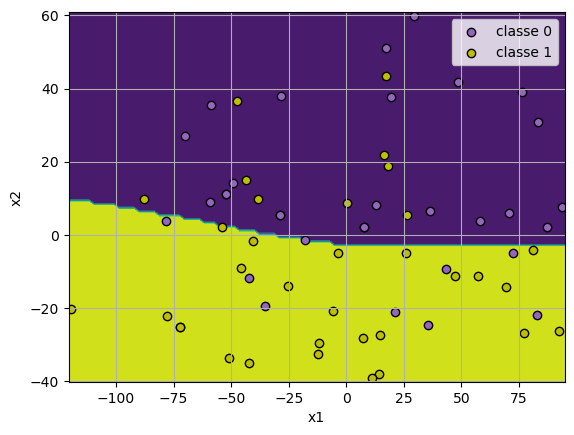

In [17]:
disp_1 = DecisionBoundaryDisplay.from_estimator(model_5,Z_test,response_method="predict",alpha=1)
disp_1.ax_.scatter(Z_test[yz_test==0,0],Z_test[yz_test==0,1],c='tab:purple',label="classe 0",edgecolor="k")
disp_1.ax_.scatter(Z_test[yz_test==1,0],Z_test[yz_test==1,1],c='y',label="classe 1",edgecolor="k")
disp_1.ax_.legend()
plt.xlabel("x1")
plt.ylabel("x2")
disp_1.ax_.grid()


Matriz de Confusão:
[[25  7]
 [ 8 26]]
Accuracy: 77.27%


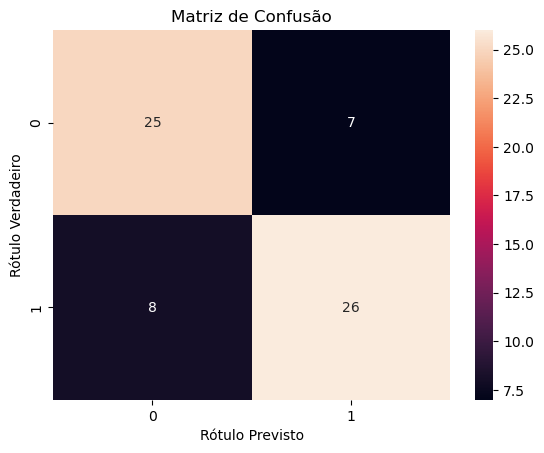

In [18]:
cm = confusion_matrix(Y_balanced_test, y_pred_1)
acc_reg_test = accuracy_score(Y_balanced_test, y_pred_1)
print("Matriz de Confusão:")
print(cm)
print("Accuracy: {:.2f}%".format(acc_reg_test * 100))


sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

Matriz de Confusão:
[[24  8]
 [ 8 26]]
Accuracy: 75.76%


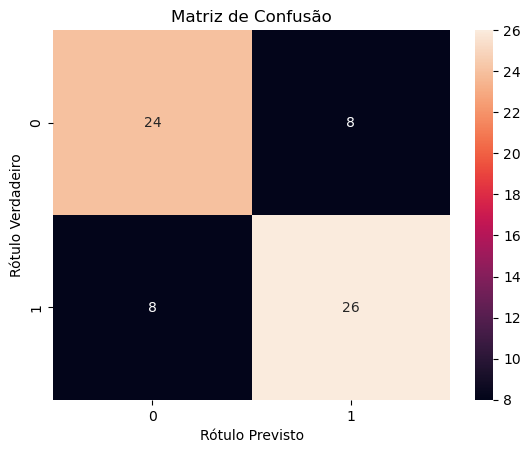

In [19]:
cm = confusion_matrix(Y_balanced_test, y_pred_2)
acc_reg_test = accuracy_score(Y_balanced_test, y_pred_2)
print("Matriz de Confusão:")
print(cm)
print("Accuracy: {:.2f}%".format(acc_reg_test * 100))


sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

Matriz de Confusão:
[[29  3]
 [ 4 30]]
Accuracy: 89.39%


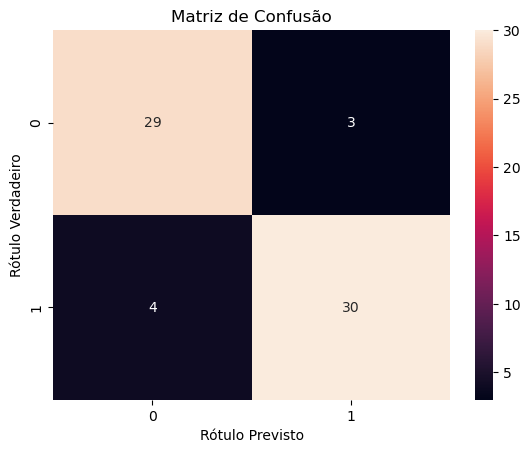

In [20]:
cm = confusion_matrix(Y_balanced_test, y_pred_3)
acc_reg_test = accuracy_score(Y_balanced_test, y_pred_3)
print("Matriz de Confusão:")
print(cm)
print("Accuracy: {:.2f}%".format(acc_reg_test * 100))


sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

Matriz de Confusão:
[[29  3]
 [ 4 30]]
Accuracy: 89.39%


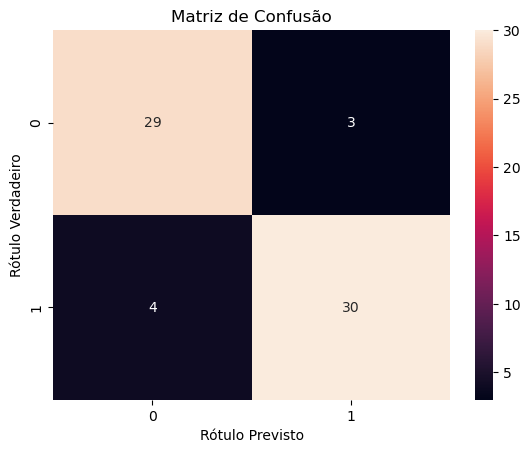

In [21]:
cm = confusion_matrix(Y_balanced_test, y_pred_4)
acc_reg_test = accuracy_score(Y_balanced_test, y_pred_4)
print("Matriz de Confusão:")
print(cm)
print("Accuracy: {:.2f}%".format(acc_reg_test * 100))


sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

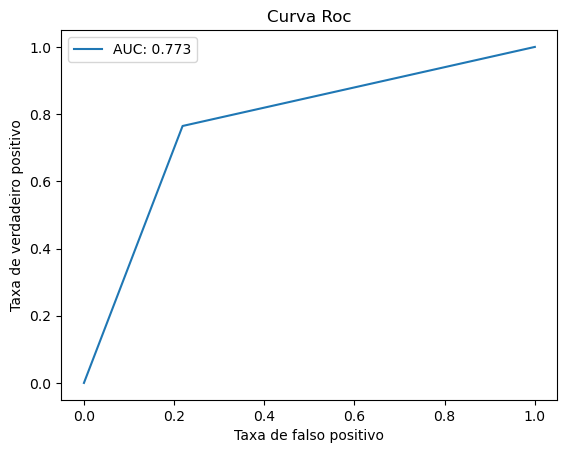

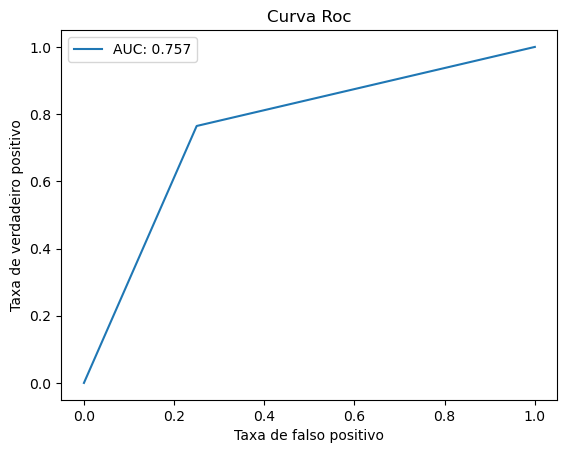

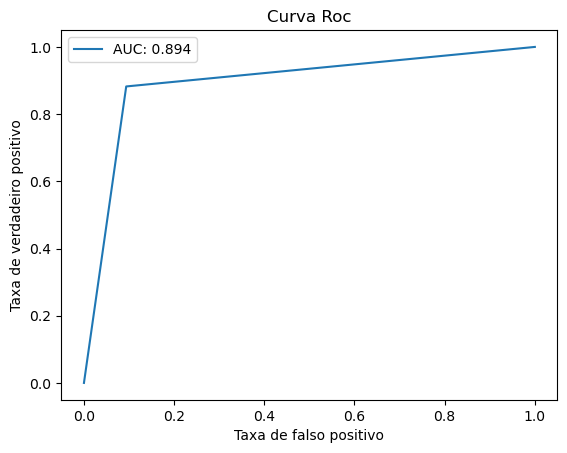

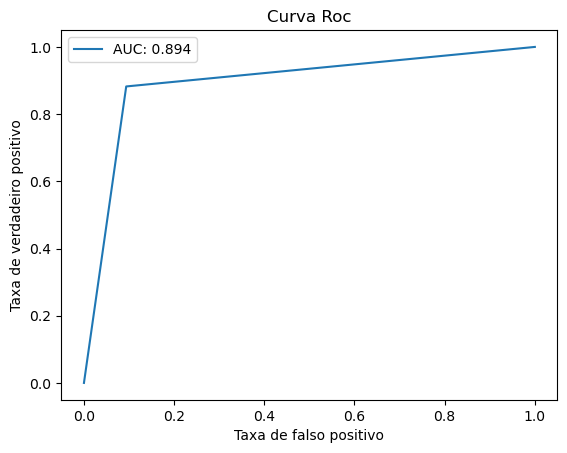

In [27]:
fpr, tpr, thresholds = roc_curve(Y_balanced_test, y_pred_1)
auc = roc_auc_score(Y_balanced_test, y_pred_1)

plt.plot(fpr, tpr, label='AUC: {:.3f}'.format(auc))
plt.xlabel('Taxa de falso positivo')
plt.ylabel('Taxa de verdadeiro positivo')
plt.title('Curva Roc')
plt.legend()
plt.show()

fpr, tpr, thresholds = roc_curve(Y_balanced_test, y_pred_2)
auc = roc_auc_score(Y_balanced_test, y_pred_2)

plt.plot(fpr, tpr, label='AUC: {:.3f}'.format(auc))
plt.xlabel('Taxa de falso positivo')
plt.ylabel('Taxa de verdadeiro positivo')
plt.title('Curva Roc')
plt.legend()
plt.show()

fpr, tpr, thresholds = roc_curve(Y_balanced_test, y_pred_3)
auc = roc_auc_score(Y_balanced_test, y_pred_3)

plt.plot(fpr, tpr, label='AUC: {:.3f}'.format(auc))
plt.xlabel('Taxa de falso positivo')
plt.ylabel('Taxa de verdadeiro positivo')
plt.title('Curva Roc')
plt.legend()
plt.show()

fpr, tpr, thresholds = roc_curve(Y_balanced_test, y_pred_4)
auc = roc_auc_score(Y_balanced_test, y_pred_4)

plt.plot(fpr, tpr, label='AUC: {:.3f}'.format(auc))
plt.xlabel('Taxa de falso positivo')
plt.ylabel('Taxa de verdadeiro positivo')
plt.title('Curva Roc')
plt.legend()
plt.show()

In [23]:
accuracy = accuracy_score(Y_balanced_test, y_pred_1)
accuracy_0 = accuracy_score(Y_balanced_train, y_pred_1t)
print(f'Accuracy with Test data: {accuracy}')
print(f'Accuracy with Train data: {accuracy_0}')


report = classification_report(Y_balanced_test, y_pred_1)
report_0 = classification_report(Y_balanced_train, y_pred_1t)
print(report)
print(report_0)

Accuracy with Test data: 0.7727272727272727
Accuracy with Train data: 0.8636363636363636
              precision    recall  f1-score   support

           0       0.76      0.78      0.77        32
           1       0.79      0.76      0.78        34

    accuracy                           0.77        66
   macro avg       0.77      0.77      0.77        66
weighted avg       0.77      0.77      0.77        66

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       133
           1       0.84      0.90      0.87       131

    accuracy                           0.86       264
   macro avg       0.87      0.86      0.86       264
weighted avg       0.87      0.86      0.86       264



In [24]:
accuracy = accuracy_score(Y_balanced_test, y_pred_2)
accuracy_0 = accuracy_score(Y_balanced_train, y_pred_2t)
print(f'Accuracy with Test data: {accuracy}')
print(f'Accuracy with Train data: {accuracy_0}')


report = classification_report(Y_balanced_test, y_pred_2)
report_0 = classification_report(Y_balanced_train, y_pred_2t)
print(report)
print(report_0)

Accuracy with Test data: 0.7575757575757576
Accuracy with Train data: 0.8446969696969697
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        32
           1       0.76      0.76      0.76        34

    accuracy                           0.76        66
   macro avg       0.76      0.76      0.76        66
weighted avg       0.76      0.76      0.76        66

              precision    recall  f1-score   support

           0       0.89      0.79      0.84       133
           1       0.81      0.90      0.85       131

    accuracy                           0.84       264
   macro avg       0.85      0.85      0.84       264
weighted avg       0.85      0.84      0.84       264



In [25]:
accuracy = accuracy_score(Y_balanced_test, y_pred_3)
accuracy_0 = accuracy_score(Y_balanced_train, y_pred_3t)
print(f'Accuracy with Test data: {accuracy}')
print(f'Accuracy with Train data: {accuracy_0}')


report = classification_report(Y_balanced_test, y_pred_3)
report_0 = classification_report(Y_balanced_train, y_pred_3t)
print(report)
print(report_0)

Accuracy with Test data: 0.8939393939393939
Accuracy with Train data: 1.0
              precision    recall  f1-score   support

           0       0.88      0.91      0.89        32
           1       0.91      0.88      0.90        34

    accuracy                           0.89        66
   macro avg       0.89      0.89      0.89        66
weighted avg       0.89      0.89      0.89        66

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       133
           1       1.00      1.00      1.00       131

    accuracy                           1.00       264
   macro avg       1.00      1.00      1.00       264
weighted avg       1.00      1.00      1.00       264



In [26]:
accuracy = accuracy_score(Y_balanced_test, y_pred_4)
accuracy_0 = accuracy_score(Y_balanced_train, y_pred_4t)
print(f'Accuracy with Test data: {accuracy}')
print(f'Accuracy with Train data: {accuracy_0}')


report = classification_report(Y_balanced_test, y_pred_4)
report_0 = classification_report(Y_balanced_train, y_pred_4t)
print(report)
print(report_0)


Accuracy with Test data: 0.8939393939393939
Accuracy with Train data: 1.0
              precision    recall  f1-score   support

           0       0.88      0.91      0.89        32
           1       0.91      0.88      0.90        34

    accuracy                           0.89        66
   macro avg       0.89      0.89      0.89        66
weighted avg       0.89      0.89      0.89        66

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       133
           1       1.00      1.00      1.00       131

    accuracy                           1.00       264
   macro avg       1.00      1.00      1.00       264
weighted avg       1.00      1.00      1.00       264

